# Problem 2: Predicting Yelp Ratings

## a)

I think it is reasonable to treat (Missing) as an explicit category, especially given all our features are categorical varibales. By using this modeling approach, it avoids throwing away data when missing values are present, especially given that our dataset is small and the missing values account for a large proprotion of inputs for some features. Treating (Missing) can be intepreted as no available information.

## b) (i)

In [1]:
# Input packages
import numpy as np
import pandas as pd
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeRegressor, plot_tree, DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, precision_score, recall_score, make_scorer, mean_absolute_error
from sklearn.model_selection import GridSearchCV, KFold
from tabulate import tabulate

In [2]:
# Input training data
yelp_train = pd.read_csv("yelp242a_train.csv")

In [3]:
# Build a regression model with all the features and treat (Missing) as the reference level
linear = smf.ols(formula="stars ~ review_count + C(GoodForKids, Treatment(reference='(Missing)'))\
                                + C(Alcohol, Treatment(reference='(Missing)'))\
                                + C(BusinessAcceptsCreditCards, Treatment(reference='(Missing)'))\
                                + C(WiFi, Treatment(reference='(Missing)'))\
                                + C(BikeParking, Treatment(reference='(Missing)'))\
                                + C(ByAppointmentOnly, Treatment(reference='(Missing)'))\
                                + C(WheelechairAccessible, Treatment(reference='(Missing)'))\
                                + C(OutdoorSeating, Treatment(reference='(Missing)'))\
                                + C(RestaurantsReservations, Treatment(reference='(Missing)'))\
                                + C(DogsAllowed, Treatment(reference='(Missing)'))\
                                + C(Caters, Treatment(reference='(Missing)'))", 
                  data=yelp_train).fit()
print(linear.summary())

                            OLS Regression Results                            
Dep. Variable:                  stars   R-squared:                       0.163
Model:                            OLS   Adj. R-squared:                  0.159
Method:                 Least Squares   F-statistic:                     48.56
Date:                Fri, 08 Mar 2024   Prob (F-statistic):          1.30e-218
Time:                        14:19:07   Log-Likelihood:                -7295.9
No. Observations:                6272   AIC:                         1.464e+04
Df Residuals:                    6246   BIC:                         1.482e+04
Df Model:                          25                                         
Covariance Type:            nonrobust                                         
                                                                               coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------

## b) (ii)

In [4]:
# Split independent and dependent variables and use dummy encoding to create dummy variables
y_train = yelp_train['stars']
x_train = pd.get_dummies(yelp_train.drop(['stars'], axis=1), drop_first=True)

# Use cross validation to select ccp_alpha with number of folds = 5
dtr = DecisionTreeRegressor()
grid_values = {'ccp_alpha': np.linspace(0, 0.10, 201)}
cv = KFold(n_splits=5, random_state=88, shuffle=True)
dtr_cv = GridSearchCV(dtr, param_grid = grid_values, scoring = 'r2', cv=cv, verbose=0)
dtr_cv.fit(x_train, y_train)

GridSearchCV(cv=KFold(n_splits=5, random_state=88, shuffle=True),
             estimator=DecisionTreeRegressor(),
             param_grid={'ccp_alpha': array([0.    , 0.0005, 0.001 , 0.0015, 0.002 , 0.0025, 0.003 , 0.0035,
       0.004 , 0.0045, 0.005 , 0.0055, 0.006 , 0.0065, 0.007 , 0.0075,
       0.008 , 0.0085, 0.009 , 0.0095, 0.01  , 0.0105, 0.011 , 0.0115,
       0.012 , 0.0125, 0.013 , 0.0135, 0.014 , 0.0145, 0.015 , 0.0155,
       0.016 , 0.0165, 0.017...
       0.072 , 0.0725, 0.073 , 0.0735, 0.074 , 0.0745, 0.075 , 0.0755,
       0.076 , 0.0765, 0.077 , 0.0775, 0.078 , 0.0785, 0.079 , 0.0795,
       0.08  , 0.0805, 0.081 , 0.0815, 0.082 , 0.0825, 0.083 , 0.0835,
       0.084 , 0.0845, 0.085 , 0.0855, 0.086 , 0.0865, 0.087 , 0.0875,
       0.088 , 0.0885, 0.089 , 0.0895, 0.09  , 0.0905, 0.091 , 0.0915,
       0.092 , 0.0925, 0.093 , 0.0935, 0.094 , 0.0945, 0.095 , 0.0955,
       0.096 , 0.0965, 0.097 , 0.0975, 0.098 , 0.0985, 0.099 , 0.0995,
       0.1   ])},
             scoring='r2')

Best ccp_alpha {'ccp_alpha': 0.001}


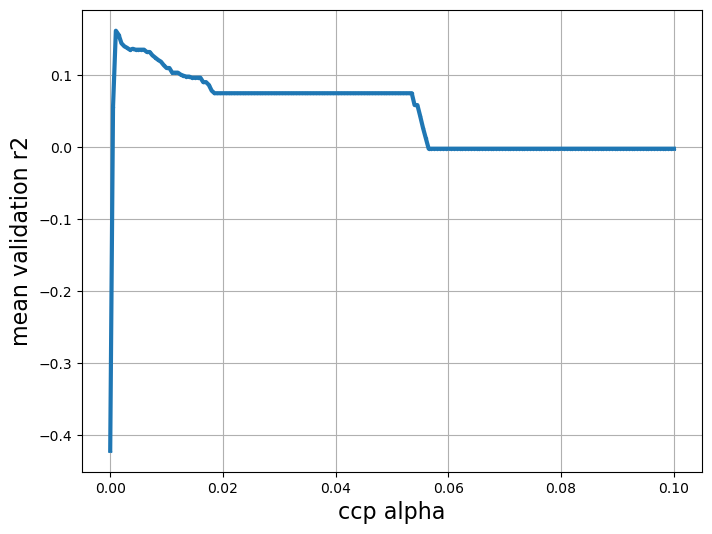

In [5]:
r2 = dtr_cv.cv_results_['mean_test_score']
ccp_dtr = dtr_cv.cv_results_['param_ccp_alpha'].data
print('Best ccp_alpha', dtr_cv.best_params_)
plt.figure(figsize=(8, 6))
plt.xlabel('ccp alpha', fontsize=16)
plt.ylabel('mean validation r2', fontsize=16)
plt.scatter(ccp_dtr, r2, s=2)
plt.plot(ccp_dtr, r2, linewidth=3)
plt.grid(True, which='both')
plt.show()

To do the cross-validation:
1. initialize a DecisionTreeRegressor
2. define the grid values for ccp alpha, i.e., cv = 201 equally spaced values between 0 and 0.1 (inclusive)
3. use the KFold function to randomly split the data into k-folds, i.e., generate 5 splits of data, set the random state at seed 88
4. use GridSearchCV function to find the best ccp alpha value, i.e., scoring = ’r2’ as the model is fitting a decision tree regressor and cv = cv
5. the best value of ccp alpha is stored as the best params attribute, which corresponds to the highest mean validation scoring, i.e., ccp_alpha = 0.001

## b) (iii)

In [6]:
# Define OSR2
def OSR2(model, X_test, y_test, y_train):
    
    y_pred = model.predict(X_test)
    SSE = np.sum((y_test - y_pred)**2)
    SST = np.sum((y_test - np.mean(y_train))**2)
                 
    return (1 - SSE/SST)

# Input testing data
yelp_test = pd.read_csv("yelp242a_test.csv")

# Split independent and dependent variables
y_test = yelp_test['stars']
x_test_dtr = pd.get_dummies(yelp_test.drop(['stars'], axis=1), drop_first=True)
x_test_linear = yelp_test.drop(['stars'], axis=1)

In [7]:
# Compute OSR2 for the two models
print('OSR2 of the linear regression model is', round(OSR2(linear, x_test_linear, y_test, y_train),3))
print('OSR2 of the regression tree model is', round(OSR2(dtr_cv.best_estimator_, x_test_dtr, y_test, y_train),3))

OSR2 of the linear regression model is 0.176
OSR2 of the regression tree model is 0.185


In [8]:
# Define MAE
def MAE(model, X_test, y_test, y_train):
    
    y_pred = model.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    return mae

# Compute MAE for the two models
print('MAE of the linear regression model is', round(MAE(linear, x_test_linear, y_test, y_train),3))
print('MAE of the regression tree model is', round(MAE(dtr_cv.best_estimator_, x_test_dtr, y_test, y_train),3))

MAE of the linear regression model is 0.621
MAE of the regression tree model is 0.613


The regression tree model performs slightly better than the linear regression model as it has slightly higher Out-of-Sample R-squared and lower Mean Absolute Error. Overall, the performances of these two models are not satisfactory.

## c)

In [9]:
# Create the new variable fourOrAbove for the training and testing data based on stars
fourOrAbove_train = [1 if i>= 4 else 0 for i in yelp_train['stars']]
fourOrAbove_test = [1 if i>= 4 else 0 for i in yelp_test['stars']]

# Duplicate the original training and testing data
yelp_train_new = yelp_train.copy(deep=True)
yelp_test_new = yelp_test.copy(deep=True)

# Add the new variable fourOrAbove into the new training and testing data
yelp_train_new['fourOrAbove'] = fourOrAbove_train
yelp_test_new['fourOrAbove'] = fourOrAbove_test

# Remove the varibale stars from the new training and testing data
yelp_train_new.drop(['stars'], axis=1, inplace=True)
yelp_test_new.drop(['stars'], axis=1, inplace=True)

## d) (i)

I think it is reasonable to weigh the false positives and false negatives equally and focus on accuracy as the primary performance metric in that in this scenario, either outcome is likely to cost the same for the business. If there is a strong indication of which one is more costly than the other for individual business, then other performance metric should be considered.

## d) (ii)

In [10]:
# Compute the predicted stars using the linear regression and the regression tree models
y_pred_linear = linear.predict(x_test_linear)
y_pred_dtr = dtr_cv.best_estimator_.predict(x_test_dtr)

# Convert the predicted stars into the new variable fourOrAbove by thresholding
y_pred_linear_new = [1 if i>= 4 else 0 for i in y_pred_linear]
y_pred_dtr_new = [1 if i>= 4 else 0 for i in y_pred_dtr]

## d) (iii)

In [11]:
# Build a logistic regression model with all the features and treat (Missing) as the reference level
logit = smf.logit(formula = "fourOrAbove ~ review_count + C(GoodForKids, Treatment(reference='(Missing)'))\
                                + C(Alcohol, Treatment(reference='(Missing)'))\
                                + C(BusinessAcceptsCreditCards, Treatment(reference='(Missing)'))\
                                + C(WiFi, Treatment(reference='(Missing)'))\
                                + C(BikeParking, Treatment(reference='(Missing)'))\
                                + C(ByAppointmentOnly, Treatment(reference='(Missing)'))\
                                + C(WheelechairAccessible, Treatment(reference='(Missing)'))\
                                + C(OutdoorSeating, Treatment(reference='(Missing)'))\
                                + C(RestaurantsReservations, Treatment(reference='(Missing)'))\
                                + C(DogsAllowed, Treatment(reference='(Missing)'))\
                                + C(Caters, Treatment(reference='(Missing)'))",
                       data = yelp_train_new).fit()
print(logit.summary())

Optimization terminated successfully.
         Current function value: 0.612512
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:            fourOrAbove   No. Observations:                 6272
Model:                          Logit   Df Residuals:                     6246
Method:                           MLE   Df Model:                           25
Date:                Fri, 08 Mar 2024   Pseudo R-squ.:                  0.1081
Time:                        14:19:42   Log-Likelihood:                -3841.7
converged:                       True   LL-Null:                       -4307.1
Covariance Type:            nonrobust   LLR p-value:                2.537e-180
                                                                               coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------------------------

## d) (iv)

In [12]:
# Split independent and dependent variables and use dummy encoding to create dummy variables
y_train_new = yelp_train_new['fourOrAbove']
x_train_new = pd.get_dummies(yelp_train_new.drop(['fourOrAbove'], axis=1), drop_first=True)

# Use cross validation to select ccp_alpha with number of folds = 5
dtc = DecisionTreeClassifier()
grid_values = {'ccp_alpha': np.linspace(0, 0.10, 201)}
cv = KFold(n_splits=5, random_state=88, shuffle=True)
dtc_cv = GridSearchCV(dtc, param_grid = grid_values, scoring = 'accuracy', cv=cv, verbose=0)
dtc_cv.fit(x_train_new, y_train_new)

GridSearchCV(cv=KFold(n_splits=5, random_state=88, shuffle=True),
             estimator=DecisionTreeClassifier(),
             param_grid={'ccp_alpha': array([0.    , 0.0005, 0.001 , 0.0015, 0.002 , 0.0025, 0.003 , 0.0035,
       0.004 , 0.0045, 0.005 , 0.0055, 0.006 , 0.0065, 0.007 , 0.0075,
       0.008 , 0.0085, 0.009 , 0.0095, 0.01  , 0.0105, 0.011 , 0.0115,
       0.012 , 0.0125, 0.013 , 0.0135, 0.014 , 0.0145, 0.015 , 0.0155,
       0.016 , 0.0165, 0.01...
       0.072 , 0.0725, 0.073 , 0.0735, 0.074 , 0.0745, 0.075 , 0.0755,
       0.076 , 0.0765, 0.077 , 0.0775, 0.078 , 0.0785, 0.079 , 0.0795,
       0.08  , 0.0805, 0.081 , 0.0815, 0.082 , 0.0825, 0.083 , 0.0835,
       0.084 , 0.0845, 0.085 , 0.0855, 0.086 , 0.0865, 0.087 , 0.0875,
       0.088 , 0.0885, 0.089 , 0.0895, 0.09  , 0.0905, 0.091 , 0.0915,
       0.092 , 0.0925, 0.093 , 0.0935, 0.094 , 0.0945, 0.095 , 0.0955,
       0.096 , 0.0965, 0.097 , 0.0975, 0.098 , 0.0985, 0.099 , 0.0995,
       0.1   ])},
             scoring='accuracy')

Best ccp_alpha {'ccp_alpha': 0.0005}


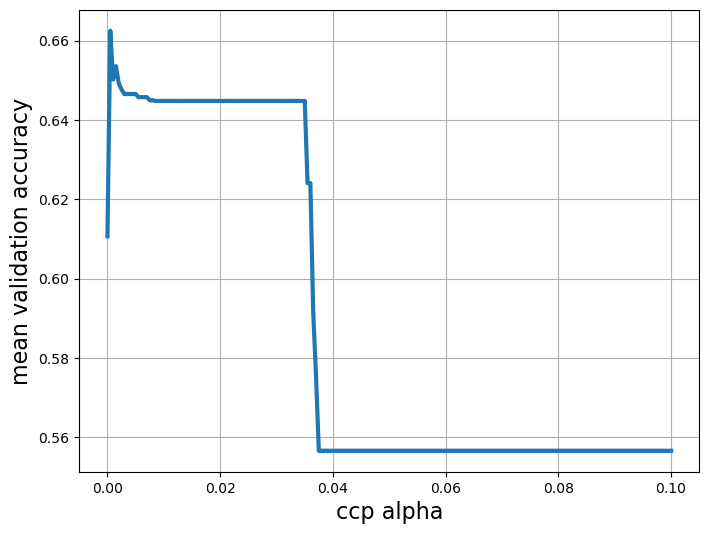

In [13]:
acc = dtc_cv.cv_results_['mean_test_score']
ccp_dtc = dtc_cv.cv_results_['param_ccp_alpha'].data
print('Best ccp_alpha', dtc_cv.best_params_)
plt.figure(figsize=(8, 6))
plt.xlabel('ccp alpha', fontsize=16)
plt.ylabel('mean validation accuracy', fontsize=16)
plt.scatter(ccp_dtc, acc, s=2)
plt.plot(ccp_dtc, acc, linewidth=3)
plt.grid(True, which='both')
plt.show()

In [14]:
# Plot the decision tree with depth = 3
print('Node count =', dtc_cv.best_estimator_.tree_.node_count)

plt.figure(figsize=(40,14),dpi=500)
plot_tree(dtc_cv.best_estimator_, 
          feature_names= list(x_train_new.columns), 
          class_names=['0','1'],
          filled=True,
          impurity=False,
          rounded=True,
          fontsize=13,
          max_depth=3)
plt.show()

Node count = 117


To do the cross-validation:
1. initialize a DecisionTreeClassifier
2. define the grid values for ccp alpha, i.e., cv = 201 equally spaced values between 0 and 0.1 (inclusive)
3. use the KFold function to randomly split the data into k-folds, i.e., generate 5 splits of data, set the random state at seed 88
4. use GridSearchCV function to find the best ccp alpha value, i.e., scoring = ’accuracy’ as the model is fitting a decision tree classifier and cv = cv
5. the best value of ccp alpha is stored as the best params attribute, which corresponds to the highest mean validation scoring, i.e., ccp_alpha = 0.0005

## d) (v)

In [15]:
# Split independent and dependent variables and use dummy encoding to create dummy variables
y_test_new = yelp_test_new['fourOrAbove']
x_test_new = pd.get_dummies(yelp_test_new.drop(['fourOrAbove'], axis=1), drop_first=True)

# Build the baseline model
belowFour_train = fourOrAbove_train.count(0)
aboveFour_train = fourOrAbove_train.count(1)
belowFour_test = np.sum(y_test_new == 0)
aboveFour_test = np.sum(y_test_new == 1)
print(pd.Series({'0': belowFour_train, '1': aboveFour_train}))

# Compute Accuracy, TPR, and FPR for the baseline model, i.e., always predicting FourOrAbove = 0 given it is the majority in the training set
acc_baseline = belowFour_test/(belowFour_test+aboveFour_test)
TPR_baseline = 0
FPR_baseline = 0

0    3491
1    2781
dtype: int64


In [16]:
# Compute Accuracy, TPR, and FPR for the linear regression model with thresholding
cm_linear = confusion_matrix(yelp_test_new['fourOrAbove'], y_pred_linear_new)

acc_linear = (cm_linear.ravel()[0]+cm_linear.ravel()[3])/sum(cm_linear.ravel())
TPR_linear = cm_linear.ravel()[3]/(cm_linear.ravel()[3]+cm_linear.ravel()[2])
FPR_linear = cm_linear.ravel()[1]/(cm_linear.ravel()[1]+cm_linear.ravel()[0])

In [17]:
# Compute Accuracy, TPR, and FPR for the regression tree model with thresholding
cm_dtr = confusion_matrix(yelp_test_new['fourOrAbove'], y_pred_dtr_new)

acc_dtr = (cm_dtr.ravel()[0]+cm_dtr.ravel()[3])/sum(cm_dtr.ravel())
TPR_dtr = cm_dtr.ravel()[3]/(cm_dtr.ravel()[3]+cm_dtr.ravel()[2])
FPR_dtr = cm_dtr.ravel()[1]/(cm_dtr.ravel()[1]+cm_dtr.ravel()[0])

In [18]:
# Compute Accuracy, TPR, and FPR for the logistic regression model
y_prob_logit = logit.predict(yelp_test_new.drop(['fourOrAbove'], axis=1))
y_pred_logit = pd.Series([1 if x >= 0.5 else 0 for x in y_prob_logit], index=y_prob_logit.index)
cm_logit = confusion_matrix(yelp_test_new['fourOrAbove'], y_pred_logit)

acc_logit = (cm_logit.ravel()[0]+cm_logit.ravel()[3])/sum(cm_logit.ravel())
TPR_logit = cm_logit.ravel()[3]/(cm_logit.ravel()[3]+cm_logit.ravel()[2])
FPR_logit = cm_logit.ravel()[1]/(cm_logit.ravel()[1]+cm_logit.ravel()[0])

In [19]:
# Compute Accuracy, TPR, and FPR for the decesion tree classification model
y_pred_dtc = dtc_cv.best_estimator_.predict(x_test_new)
cm_dtc = confusion_matrix(yelp_test_new['fourOrAbove'], y_pred_dtc)

acc_dtc = (cm_dtc.ravel()[0]+cm_dtc.ravel()[3])/sum(cm_dtc.ravel())
TPR_dtc = cm_dtc.ravel()[3]/(cm_dtc.ravel()[3]+cm_dtc.ravel()[2])
FPR_dtc = cm_dtc.ravel()[1]/(cm_dtc.ravel()[1]+cm_dtc.ravel()[0])

In [20]:
data = [
    ["Perf. Matrics", "Baseline", "Linear Reg w/threshold", "Reg Tree w/threshold", "Logistic Reg", "Class. Tree"],
    ["Accuracy", round(acc_baseline, 4), round(acc_linear, 4), round(acc_dtr, 4), round(acc_logit, 4), round(acc_dtc, 4)],
    ["TPR", round(TPR_baseline, 4), round(TPR_linear, 4), round(TPR_dtr, 4), round(TPR_logit, 4), round(TPR_dtc, 4)],
    ["FPR", round(FPR_baseline, 4), round(FPR_linear, 4), round(FPR_dtr, 4), round(FPR_logit, 4), round(FPR_dtc, 4)]
]
print(tabulate(data))

-------------  --------  ----------------------  --------------------  ------------  -----------
Perf. Matrics  Baseline  Linear Reg w/threshold  Reg Tree w/threshold  Logistic Reg  Class. Tree
Accuracy       0.5636    0.6347                  0.644                 0.6793        0.6652
TPR            0         0.2123                  0.2634                0.4876        0.4749
FPR            0         0.0383                  0.0614                0.1723        0.1875
-------------  --------  ----------------------  --------------------  ------------  -----------


The results seem reasonable to me. Across the three performance metrics, Logistic Regression model has the highest accuracy rate and the highest True Positive Rate while Linear Regression model with thresholding has the lowest False Positive Rate. Classification Tree model has better accuracy and TPR but higher FPR than the Regression Tree model. The trade-off exists between TPR and FPR, which means a higher TPR will lead to a higher FPR. Additinally, Classification Tree model and Regression Tree model are generally simpler and provide better interpretation to non-technical audiences, although neigher of which outperform the Logistic Regression model. Given above analysis, I would recommend to use the Classification Tree model for this problem in that it has relatively good performance in terms of accuracy and TPR and it provides reasonable, explainable, and actionable insights and solutions for the stakeholders.

## e)

In [21]:
# Train a shallow classification tree
dtc_shallow = DecisionTreeClassifier(max_leaf_nodes = 12, ccp_alpha=0.0005)
dtc_shallow = dtc_shallow.fit(x_train_new, y_train_new)

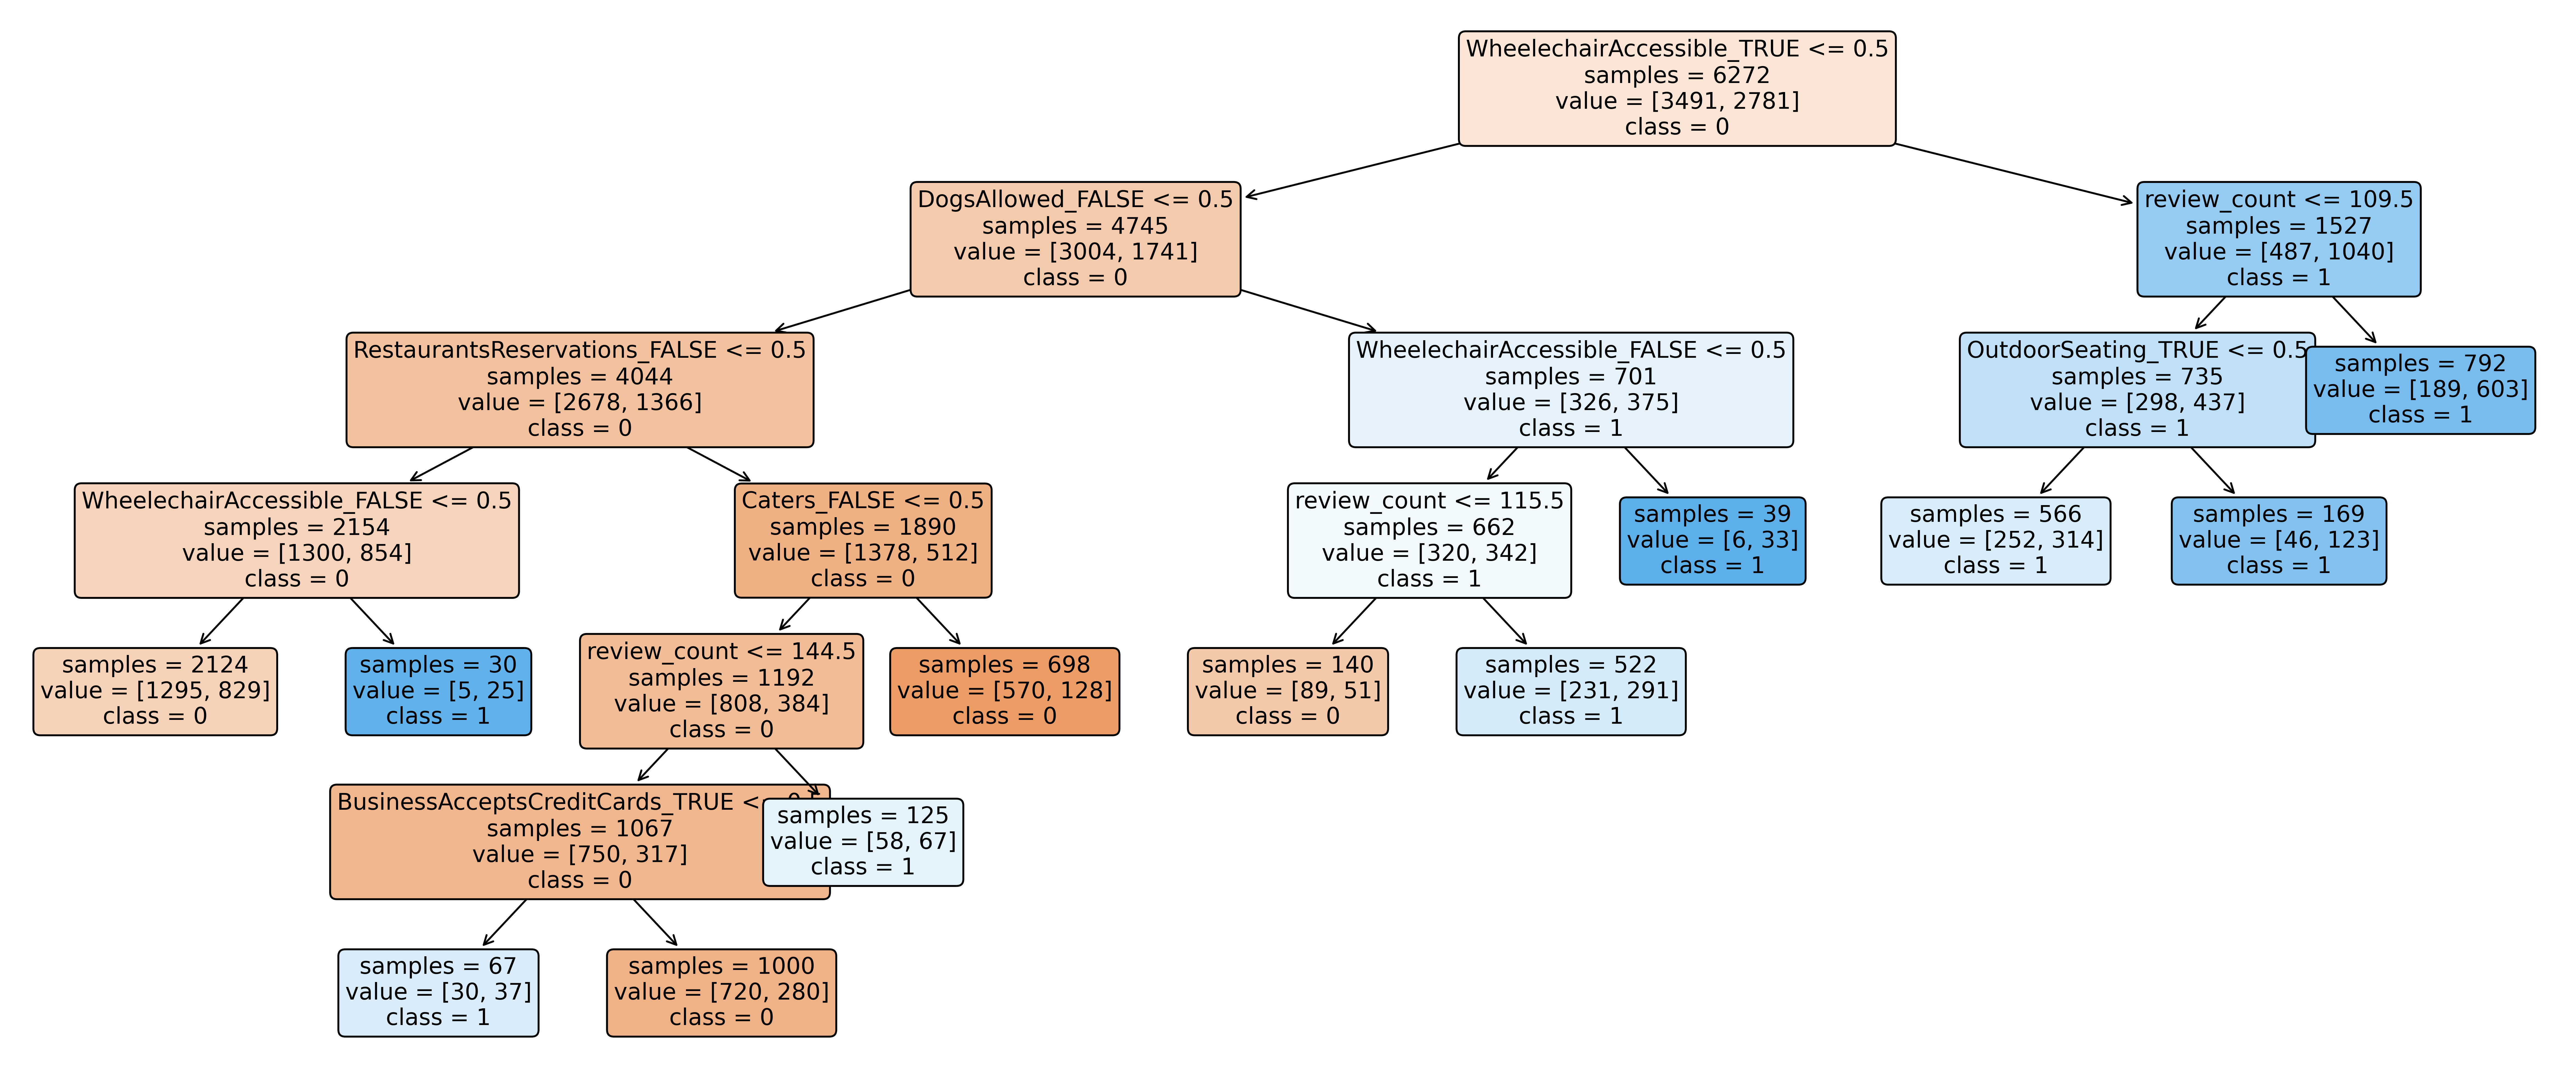

In [22]:
plt.figure(figsize=(24,10),dpi=500)
plot_tree(dtc_shallow, 
          feature_names= list(x_train_new.columns), 
          class_names=['0','1'],
          filled=True,
          impurity=False,
          rounded=True,
          fontsize=12)
plt.show()

Since only three tips are required, a shallower Classification Tree is trained with max leaf nodes = 12. Given the above plot above, it can be observed that the first three splits that lead to FourOrAbove are the blue nodes on the right side of the tree. In particular, WheelechairAccessible_TRUE, DogsAllowed_FALSE, and OutdoorSeating_TRUE are the decision nodes. Therefore, it can be concluded that being wheelechair accessible, allowing dogs, and having outdoor seating are the top three tips to achieve a high rating.